In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
from keras_vggface.vggface import VGGFace
from keras.layers import Input

In [2]:
batch_size = 32
target_size = (224, 224)
input_shape=(224, 224, 3)
seed=1337
adam_lr = 0.001
FC = 2048
num_classes = 1
patience = 3
dense_dropout = 0
cnn_dropout = 0
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=5
loss = 'binary_crossentropy'
metrics = ['accuracy']
model_name = 'vggface_gender.h5'

In [3]:
train_data = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_data = ImageDataGenerator( rescale = 1.0/255)

test_data = ImageDataGenerator( rescale = 1.0/255)

In [4]:
print("Training Data:")
train_generator = train_data.flow_from_directory('./gender_classification/Training',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size )     

print("Validation Data:")
validation_generator =  validation_data.flow_from_directory( './gender_classification/Validation',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

print("Test Data:")
test_generator = test_data.flow_from_directory('./gender_classification/Test',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'binary',
                                                          seed=seed,
                                                          target_size = target_size)

Training Data:
Found 47009 images belonging to 2 classes.
Validation Data:
Found 5811 images belonging to 2 classes.
Test Data:
Found 5820 images belonging to 2 classes.


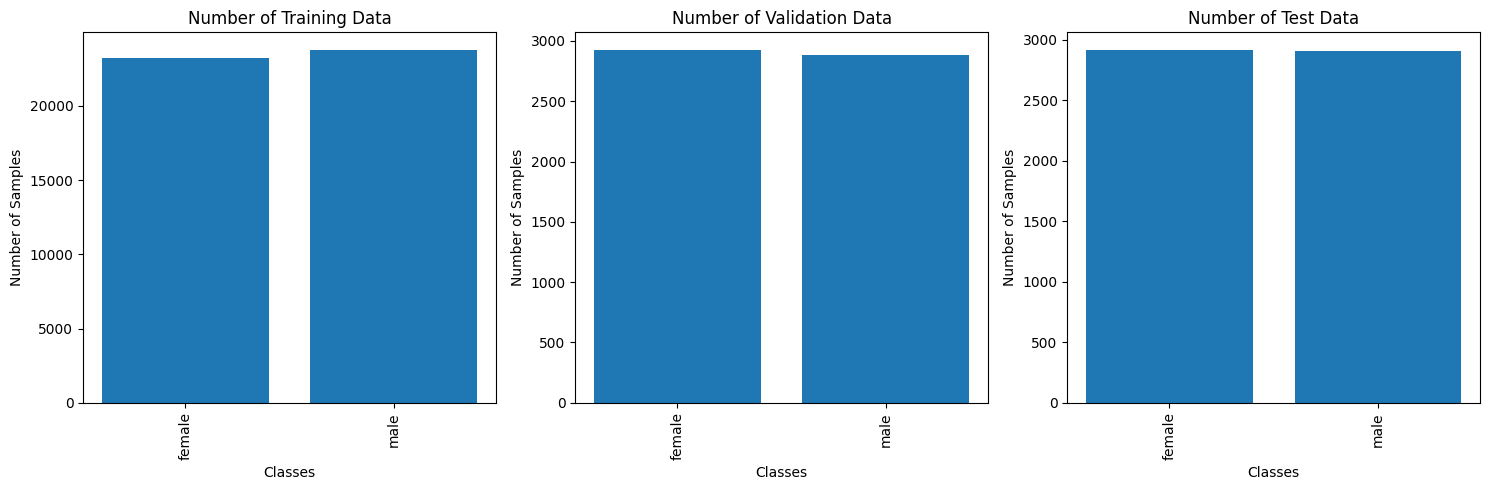

In [5]:
import os
import matplotlib.pyplot as plt

def count_files(directory):
    """
    Counts the number of files in each subdirectory of a given directory.
    Assumes that each subdirectory represents a class.
    """
    counts = []
    class_names = []
    # Walk through each subdirectory in the directory
    for subdir in sorted(os.listdir(directory)):
        path = os.path.join(directory, subdir)
        if os.path.isdir(path):
            # Count the number of files in this subdirectory
            num_files = len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
            counts.append(num_files)
            class_names.append(subdir)
    return counts, class_names

def plot_histogram(counts, class_names, title, ax):
    """
    Plots a histogram of the number of files for each class.
    """
    ax.bar(class_names, counts)
    ax.set_title(f'Number of {title} Data')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Samples')
    ax.tick_params(axis='x', rotation=90)

# Directories
training_dir = './gender_classification/Training'
validation_dir = './gender_classification/Validation'
test_dir = './gender_classification/Test'

# Count files in each directory
training_counts, training_classes = count_files(training_dir)
validation_counts, validation_classes = count_files(validation_dir)
test_counts, test_classes = count_files(test_dir)

# Plot histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_histogram(training_counts, training_classes, 'Training', axs[0])
plot_histogram(validation_counts, validation_classes, 'Validation', axs[1])
plot_histogram(test_counts, test_classes, 'Test', axs[2])

plt.tight_layout()
plt.show()

In [82]:
# Based on VGG16 architecture -> old paper(2015)
vggface = VGGFace(model='vgg16') # or VGGFace() as default

In [83]:
vggface.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [84]:
model_old = Sequential()

for layer in vggface.layers[:-6]:
    model_old.add(layer)

for layer in model_old.layers:
    layer.trainable = False
    
model_old.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0         
                                                                 
 conv3_1 (Conv2D)            (None, 56, 56, 256)     

In [85]:
test_input = np.random.random((1, 224, 224, 3))  # Replace with your input shape
model_old.predict(test_input).shape

1/1 [==============================] - 0s 115ms/step


(1, 25088)

In [86]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    model_old,
    # Flatten(),
    Dense(FC, activation='relu'),
    Dropout(dense_dropout),
    Dense(num_classes, activation='sigmoid')
])
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 25088)             14714688  
                                                                 
 dense_24 (Dense)            (None, 2048)              51382272  
                                                                 
 dropout_7 (Dropout)         (None, 2048)              0         
                                                                 
 dense_25 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 66,099,009
Trainable params: 51,384,321
Non-trainable params: 14,714,688
_________________________________________________________________


In [87]:
model.compile(optimizer=Adam(adam_lr),
              loss=loss
              ,metrics=metrics)

In [88]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint(model_name)

es = EarlyStopping(verbose=verbose, patience=patience)

In [89]:
# Check the accuracy of the model before training
print("Accuracy before training")
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


# Train the model
print("Training the model")
# history = model.fit(train_generator,
#                     epochs = epochs,
#                     validation_data = validation_generator,
#                     steps_per_epoch = steps_per_epoch,
#                     validation_steps = validation_steps,
#                     callbacks = [lrd, mcp])
hist = model.fit(train_generator,
                  steps_per_epoch = train_generator.samples // batch_size,
                  validation_data = validation_generator, 
                  validation_steps = validation_generator.samples // batch_size,
                  epochs = epochs,
                  verbose = 1,
                  callbacks=[lrd, mcp])
# Save the model
print("Saving the model")
model.save(model_name)

# Check the accuracy of the model after training
print("Accuracy after training")
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Accuracy before training
182/182 [==============================] - 14s 72ms/step - loss: 0.6951 - accuracy: 0.4997
Test Loss: 0.6950876116752625
Test Accuracy: 0.4996563494205475
Training the model
Epoch 1/5
1469/1469 [==============================] - 320s 217ms/step - loss: 0.1375 - accuracy: 0.9532 - val_loss: 0.0839 - val_accuracy: 0.9710 - lr: 0.0010
Epoch 2/5
1469/1469 [==============================] - 301s 205ms/step - loss: 0.1202 - accuracy: 0.9609 - val_loss: 0.0887 - val_accuracy: 0.9701 - lr: 0.0010
Epoch 3/5
1469/1469 [==============================] - 304s 207ms/step - loss: 0.1159 - accuracy: 0.9611 - val_loss: 0.0845 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 4/5
1469/1469 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9625
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1469/1469 [==============================] - 303s 206ms/step - loss: 0.1115 - accuracy: 0.9625 - val_loss: 0.0956 - val_accuracy: 0.9698 - lr: 0.001

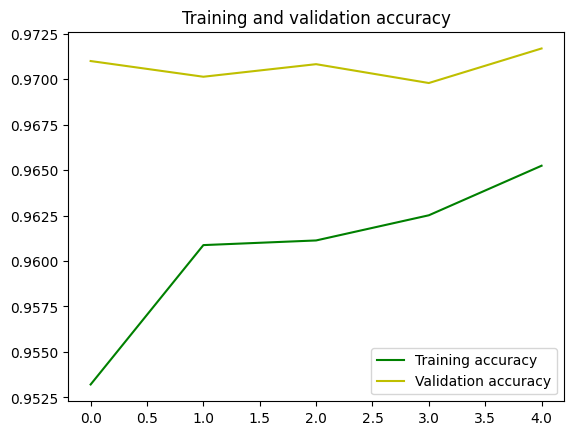

<Figure size 640x480 with 0 Axes>

In [90]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

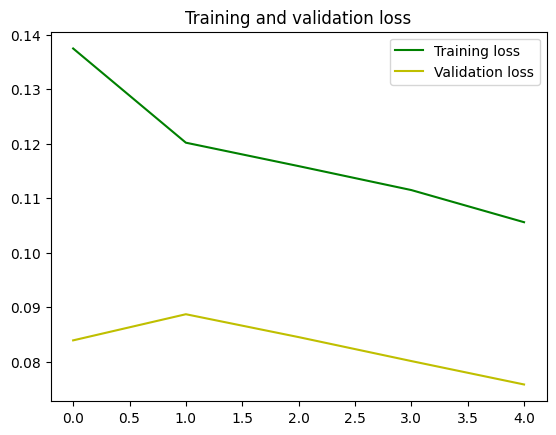

<Figure size 640x480 with 0 Axes>

In [4]:
# plot loss curves
import matplotlib.pyplot as plt
loss = [0.1375, 0.1202, 0.1159, 0.1115, 0.1056]
epochs = range(len(loss))
val_loss = [0.0839, 0.0887, 0.0845, 0.0801,  0.0758]
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


In [5]:
model = load_model('vggface_gender_9744.h5')

In [110]:
# Loading the model and testing it on a sample image
print("Loading the model")
# model = load_model('model.h5')

print("Testing the model on a sample image")
# sample_img_path = './my_friends/cumali.jpeg'
sample_img_path = './my_friends/cemre2.jpg'
# sample_img_path = './my_friends/bayzan.jpg'
# sample_img_path = './my_friends/engin.jpg'
# sample_img_path = './my_friends/halimcan.jpg'
# sample_img_path = './my_friends/halim2.jpeg'
# sample_img_path = './my_friends/cemre2.jpg'
# sample_img_path = './my_friends/engin2.jpg'
# sample_img_path = './my_friends/erto.jpg'
# sample_img_path = './my_friends/harry.jpg'
sample_img = tf.keras.preprocessing.image.load_img(sample_img_path, target_size=target_size)
sample_img = tf.keras.preprocessing.image.img_to_array(sample_img)
sample_img = np.expand_dims(sample_img, axis=0)
sample_img = sample_img/255
prediction = model.predict(sample_img)
print(prediction)




Loading the model
Testing the model on a sample image
1/1 [==============================] - 0s 12ms/step
[[0.01874706]]


In [11]:
model = load_model('vggface_gender_9744.h5')
score = model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

 79/182 [============>.................] - ETA: 4s - loss: 3.1160 - accuracy: 0.5000

KeyboardInterrupt: 

In [7]:
def id2label(predicted_class):
    if predicted_class <= 0.5:
        return "female"
    return "male"

In [18]:
test_generator =  test_data.flow_from_directory( './gender_classification/Test',
                                                    batch_size  = batch_size,
                                                    class_mode  = 'binary',
                                                    seed=seed,
                                                    target_size = target_size,
                                                    shuffle=False)

# Plotting some of the misclassified images with their true and predicted labels
print("Plotting some of the misclassified images with their true and predicted labels")
test_generator.reset()
pred = model.predict(test_generator)
pred = pred.flatten()
pred = (pred > 0.5).astype(int)
# pred = np.argmax(pred, axis=1)
# print(pred)
print(test_generator.classes)
print(test_generator.class_indices)
print(test_generator.filenames)
misclassified_idx = np.where(pred != test_generator.classes)[0]
# Labels of the misclassified images
misclassified_labels = test_generator.classes[misclassified_idx]
print("Number of misclassified samples = ", len(misclassified_idx))
print("Total number of samples = ", len(test_generator.classes))
print("Percentage of misclassified samples = ", len(misclassified_idx)/len(test_generator.classes)*100, "%")


Found 5820 images belonging to 2 classes.
Plotting some of the misclassified images with their true and predicted labels
182/182 [==============================] - 8s 42ms/step
[0 0 0 ... 1 1 1]
{'female': 0, 'male': 1}
['female\\112944.jpg.jpg', 'female\\112950.jpg.jpg', 'female\\112953.jpg.jpg', 'female\\112956.jpg.jpg', 'female\\112959.jpg.jpg', 'female\\112961.jpg.jpg', 'female\\112967.jpg.jpg', 'female\\112968.jpg.jpg', 'female\\112970.jpg.jpg', 'female\\112973.jpg.jpg', 'female\\112974.jpg.jpg', 'female\\112979.jpg.jpg', 'female\\112987.jpg.jpg', 'female\\112988.jpg.jpg', 'female\\112992.jpg.jpg', 'female\\112993.jpg.jpg', 'female\\113000.jpg.jpg', 'female\\113002.jpg.jpg', 'female\\113005.jpg.jpg', 'female\\113006.jpg.jpg', 'female\\113010.jpg.jpg', 'female\\113012.jpg.jpg', 'female\\113013.jpg.jpg', 'female\\113024.jpg.jpg', 'female\\113025.jpg.jpg', 'female\\113027.jpg.jpg', 'female\\113028.jpg.jpg', 'female\\113030.jpg.jpg', 'female\\113033.jpg.jpg', 'female\\113036.jpg.jpg',

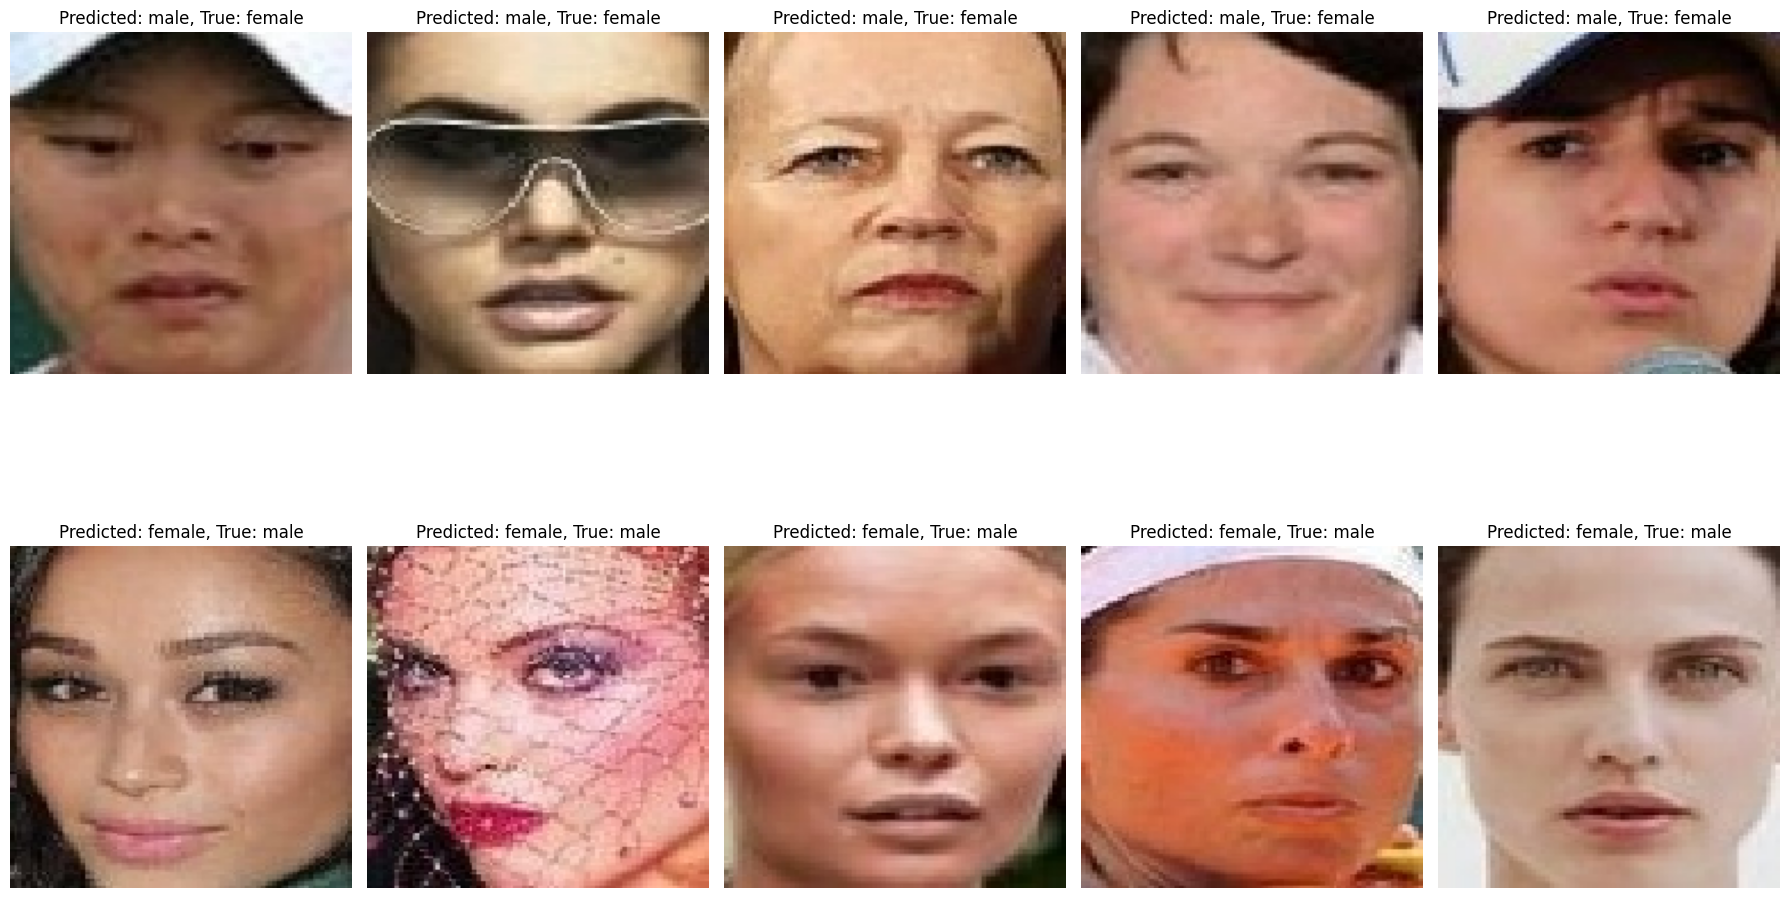

In [23]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ... [your previous code and function definitions] ...

def plot_misclassified_images(misclassified_idx, pred, true_labels, directory, filenames, id2label, target_size=(150, 150)):
    num_classes = 2
    images_per_class = 5
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(18, 12))  # Adjust the figsize if needed
    axes = axes.ravel()

    misclassified_counters = [0] * num_classes
    subplot_idx = 0

    img_paths = []
    for idx in misclassified_idx:
        true_label = true_labels[idx]
        if misclassified_counters[true_label] < images_per_class:
            misclassified_counters[true_label] += 1

            img_path = os.path.join(directory, filenames[idx])
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            axes[subplot_idx].imshow(img.astype('uint8'))
            axes[subplot_idx].set_title(f"Predicted: {id2label(pred[idx])}, True: {id2label(true_label)}")
            axes[subplot_idx].axis('off')
            subplot_idx += 1
            img_paths.append(img_path)

            if subplot_idx >= num_classes * images_per_class:
                break

    for i in range(subplot_idx, num_classes * images_per_class):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    return img_paths

# Example of calling the function
img_paths = plot_misclassified_images(misclassified_idx, pred, test_generator.classes, test_generator.directory, test_generator.filenames, id2label)


In [24]:
img_paths

['./gender_classification/Test\\female\\113104.jpg.jpg',
 './gender_classification/Test\\female\\113197.jpg.jpg',
 './gender_classification/Test\\female\\113427.jpg.jpg',
 './gender_classification/Test\\female\\113656.jpg.jpg',
 './gender_classification/Test\\female\\114305.jpg.jpg',
 './gender_classification/Test\\male\\063571.jpg.jpg',
 './gender_classification/Test\\male\\063613.jpg.jpg',
 './gender_classification/Test\\male\\063615.jpg.jpg',
 './gender_classification/Test\\male\\063876.jpg.jpg',
 './gender_classification/Test\\male\\063920.jpg.jpg']

{'female': 0, 'male': 1}
182/182 [==============================] - 8s 43ms/step
              precision    recall  f1-score   support

      female       0.97      0.98      0.97      2916
        male       0.98      0.97      0.97      2904

    accuracy                           0.97      5820
   macro avg       0.97      0.97      0.97      5820
weighted avg       0.97      0.97      0.97      5820



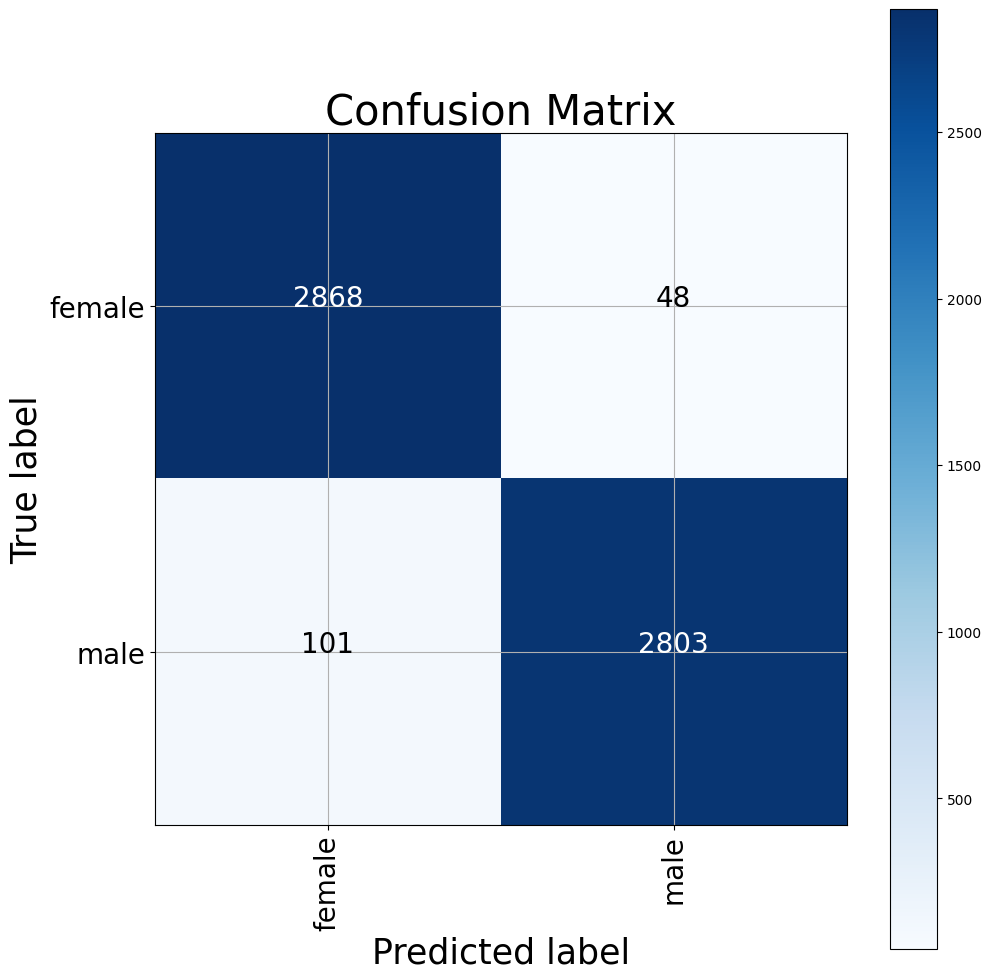

In [26]:
# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    
    
        plt.figure(figsize=(10,10))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=30)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
        plt.yticks(tick_marks, classes, fontsize=20)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
    
        # Labeling the plot
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            # plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
            plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', fontsize=25)
        plt.xlabel('Predicted label', fontsize=25)

# Get the labels of the test images.
test_labels = test_generator.classes

# We need these to plot the confusion matrix.
test_labels

# Print the label associated with each class
print(test_generator.class_indices)

# Generate predictions
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size+1, verbose=1)
predictions = predictions.flatten()
predicted_classes = (predictions > 0.5).astype(int)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == test_labels)[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels)[0]

# Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = validation_generator.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Print the classification report
from sklearn.metrics import classification_report
# Generate a classification report

report = classification_report(test_labels, predicted_classes, target_names=validation_generator.class_indices.keys())

print(report)

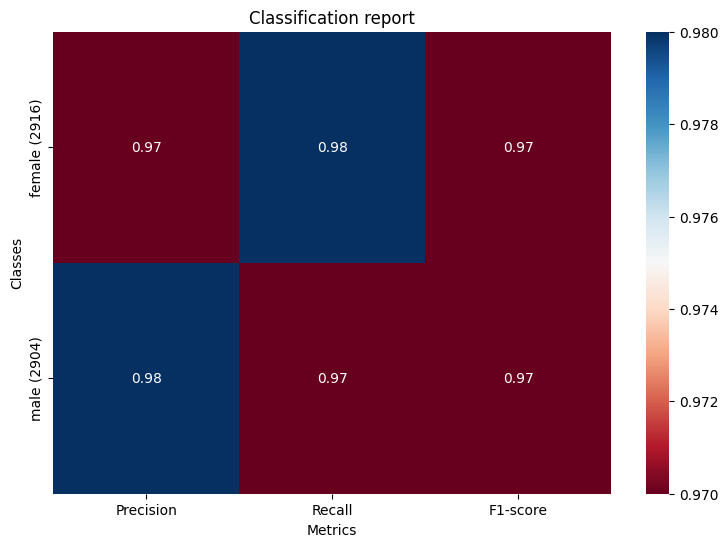

In [27]:

# Plot the classification report
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_classification_report(classificationReport,
                                 title='Classification report',
                                 cmap='RdBu'):
     '''
     Plot scikit-learn classification report.
     Extension based on https://stackoverflow.com/a/31689645/395857
     '''
     classificationReport = classificationReport.replace('\n\n', '\n')
     classificationReport = classificationReport.replace(' / ', '/')
     lines = classificationReport.split('\n')
    
     classes, plotMat, support, class_names = [], [], [], []
     for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
          t = line.strip().split()
          if len(t) < 2:
                continue
          classes.append(t[0])
          v = [float(x) for x in t[1: len(t) - 1]]
          support.append(int(t[-1]))
          class_names.append(t[0])
          plotMat.append(v)
    
     plotMat = np.array(plotMat)
     xticklabels = ['Precision', 'Recall', 'F1-score']
     yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                     for idx, sup in enumerate(support)]
    
     plt.figure(figsize=(9, 6))
     sns.heatmap(plotMat, xticklabels=xticklabels,
                 yticklabels=yticklabels, cmap=cmap, annot=True, fmt='.2f')
     plt.title(title)
     plt.ylabel('Classes')
     plt.xlabel('Metrics')
     plt.savefig('classification_report.png')
     plt.show()

plot_classification_report(report)

Testing on our dataset

In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
from keras_vggface.vggface import VGGFace
from keras.layers import Input
from mtcnn.mtcnn import MTCNN

In [2]:
batch_size = 256
target_size = (224, 224)
input_shape=(224, 224, 3)
epochs=50
seed=1337

In [3]:
print("Loading the model")
model = load_model('vggface_gender_9744.h5')

Loading the model


In [5]:
test_data = ImageDataGenerator( rescale = 1.0/255)
test_generator = test_data.flow_from_directory('./our_dataset/gender',
                                                          batch_size  = batch_size,
                                                          class_mode  = 'categorical',
                                                          seed=seed,
                                                          target_size = target_size,
                                                          shuffle=False)

# Plotting some of the misclassified images with their true and predicted labels
print("Plotting some of the misclassified images with their true and predicted labels")
test_generator.reset()
pred = model.predict(test_generator)
pred = pred.flatten()
pred = (pred > 0.5).astype(int)
# pred = np.argmax(pred, axis=1)
# print(pred)
print(test_generator.classes)
print(test_generator.class_indices)
print(test_generator.filenames)
misclassified_idx = np.where(pred != test_generator.classes)[0]
# Labels of the misclassified images
misclassified_labels = test_generator.classes[misclassified_idx]
print("Number of misclassified samples = ", len(misclassified_idx))
print("Total number of samples = ", len(test_generator.classes))
print("Percentage of misclassified samples = ", len(misclassified_idx)/len(test_generator.classes)*100, "%")


Found 59 images belonging to 2 classes.
Plotting some of the misclassified images with their true and predicted labels
1/1 [==============================] - 5s 5s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
{'female': 0, 'male': 1}
['female\\12312412.jpg', 'female\\72ca897397cc1d901e52ae1757ddf5c4.jpg', 'female\\73461000-hispanic-teen-girl-in-park.jpg', 'female\\8e516cbc55d6fa2e793d587c409a6cd6.jpg', 'female\\IMG_20200216_164612.jpg', 'female\\IMG_20200216_164649.jpg', 'female\\IMG_20200428_213749.jpg', 'female\\IMG_20200515_213247.jpg', 'female\\asdasdqweas.jpg', 'female\\asdq�wkd.jpg', 'female\\askdjajw�ojasd.jpg', 'female\\ef2a7da6ea5d46af839049c006bf3097.jpeg', 'female\\eorgjoegrergegr.jpg', 'female\\lkpka�c�asca.jpg', 'female\\o�qjwdojasdajd.jpg', 'female\\qowkdasz.jpg', 'female\\qwdasdajsd.jpg', 'female\\stock-photo-devostock-asian-cute-teen-girl-glass-door-4k-175771.jpg', 'male\\09cb546053bf2d6169